# Generate Sentinel 2 chips

## Data generation

Steps:

The code for calculating the image chips is implemented the Jupyter Notebook *01.03-bm-chips-s2-planetary-computer-code*. This needs to run in Microsfts Planetary Computer.

A longer version of the code with an appendix showing the development process can be found [here](https://github.com/benmack/PlanetaryComputerNotebooks/blob/main/Calculate%20temporal%20statistical%20metrics%20from%20cloud-masked%20Sentinel%202%20data%20on%20small%20areas%20(image%20chips).ipynb)

Input data / dependencies:
* *data/intermediate/target/sol_chem_pnts_horizons_africa_chip_geometries.gpkg*

Output data:
* *data\intermediate\chips\s2_metrics_p*
  * */data/{olc_id}.nc*: netcdf file with percentiles and mid 50 and mid 80 ranges
  * */metadata_s2_scenes/{olc_id}.csv*: metadata file listing the scenes found by the query and the scenes used to calculate the metrics, where the column *unique_metrics* is `True` 

## Read chip data

In [1]:
import pandas as pd
import xarray as xr
import os
import fsspec
import geopandas as gpd
import pandas as pd
import xarray as xr
import io
import warnings

from keplergl import KeplerGl


### From a local file

In [4]:
basedir_chips = '../data/intermediate/chips/s2_metrics_p'
olc_id = '7C28GHFX+PFH'
filename_nc = f"{basedir_chips}/data/{olc_id}.nc"
filename_s2_scenes = f"{basedir_chips}/metadata_s2_scenes/{olc_id}.csv"

s2_scenes = pd.read_csv(filename_s2_scenes)
display(s2_scenes.head(3))

ds = xr.open_dataset(filename_nc)
ds

,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20191228T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.001042,S2A,MSIL2A,20191228T111451,R137,T28PFS,20201003T103031,2019-12-28,22015,True
1,S2B_MSIL2A_20191223T111359_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.091051,S2B,MSIL2A,20191223T111359,R137,T28PFS,20201003T084707,2019-12-23,22015,True
2,S2A_MSIL2A_20191218T111451_R137_T28PFS_2020100...,"POLYGON ((-14.085114 10.85412139, -13.080841 1...",0.159067,S2A,MSIL2A,20191218T111451,R137,T28PFS,20201003T062751,2019-12-18,22015,True


<xarray.Dataset>
Dimensions:      (time_period: 2, y: 129, x: 129, metric: 7)
Coordinates:
  * time_period  (time_period) object 'season_1' 'season_2'
  * x            (x) float64 6.743e+05 6.743e+05 ... 6.756e+05 6.756e+05
  * y            (y) float64 1.164e+06 1.164e+06 ... 1.163e+06 1.163e+06
  * metric       (metric) object 'p010' 'p025' 'p050' ... 'pmid50' 'pmid80'
    spatial_ref  int64 ...
Data variables:
    B02          (time_period, y, x, metric) uint16 ...
    B04          (time_period, y, x, metric) uint16 ...
    B8A          (time_period, y, x, metric) uint16 ...
    B09          (time_period, y, x, metric) uint16 ...
    B11          (time_period, y, x, metric) uint16 ...
    B12          (time_period, y, x, metric) uint16 ...

### From S3

In [5]:
# warnings.simplefilter("ignore", 'FormatterWarning: text/html formatter returned invalid type <class')


# parquet because i do not manage to read the geopackage from s3 with fsspec
# gdf = gpd.read_file('../data/intermediate/aux/sol_chem_pnts_horizons_africa_chip_geometries.gpkg')
# gdf.to_parquet(path='../data/intermediate/aux/sol_chem_pnts_horizons_africa_chip_geometries.parquet')

class ChipS2:
    def __init__(self, data, df_scenes):
        self.df_scenes = df_scenes
        self.data = data

    def viz_compare_time_periods(self, 
                                bands=["B11", "B8A", "B04"],
                                metrics=['p010', 'p025', 'p050', 'p075', 'p090', 'pmid50', 'pmid80']):

        fcc = self.data[bands].sel(
            metric=metrics
            ).to_array().rename({'variable': 'band'})
        fcc.plot.imshow(row='metric', 
                        col='time_period', 
                        rgb="band", 
                        robust=True, 
                        size=6)


class ChipsReader:
    def __init__(self, 
        s3_uri_chips='s3://mi4people-soil-project/chips',
        cache_storage='./tmp/files/',
        check_files=False,
        secrets_file_path=None):

        # https://s3fs.readthedocs.io/en/latest/index.html#credentials

        self._s3_uri_chips = s3_uri_chips
        self._cache_storage = cache_storage
        self._check_files = check_files
        self._secrets_file_path = secrets_file_path
        
        # setup data 
        self._uri_chip_geometries = self._s3_uri_chips + '/sol_chem_pnts_horizons_africa_chip_geometries.parquet'
        self._uri_logs = self._s3_uri_chips + '/s2_metrics_p/s2-chips-generation.log'
        self._uri_data = self._s3_uri_chips + '/s2_metrics_p/data'
        self._uri_metadata = self._s3_uri_chips + '/s2_metrics_p/meatadata_s2_scenes'
        self._uri_data = self._s3_uri_chips + '/s2_metrics_p/data'

        # setup environmental variables with secrets if given
        if self._secrets_file_path:
            self._setup_access()

        self._fs = fsspec.filesystem("filecache", target_protocol='s3',
                                     cache_storage=self._cache_storage,
                                     check_files=self._check_files)

        # load data
        self._logs = None
        self.gemoetries = None
        self._get_geometries()
        

    def _get_geometries(self):
        with self._fs.open(self._uri_chip_geometries, mode='rb') as file:
            gdf = gpd.read_parquet(file)
        self._get_logs()
        missing_locations = []
        for line in self._logs.split('\n'):
            if 'No scenes found for' in line:
                missing_locations.append(line.split('No scenes found for ')[1])
        gdf['missing_data'] = False
        gdf.loc[gdf['olc_id'].isin(missing_locations), 'missing_data'] = True
        # polygons
        self.gdf = gdf
        # same as points
        self.gdf_points = gpd.GeoDataFrame(
            self.gdf.drop('geometry', axis=1),
            geometry=gpd.points_from_xy(self.gdf.longitude, self.gdf.latitude), crs='epsg:4326')


    def _get_logs(self):
        with self._fs.open(self._uri_logs, mode='r') as file:
            logs = file.read()
        self._logs = logs

    def get_chip(self, olc_id):
        with self._fs.open(self._uri_metadata + f'/{olc_id}.csv', mode='rb') as file:
            scenes = pd.read_csv(file, index_col=0)
        with self._fs.open(self._uri_data + f'/{olc_id}.nc', mode='rb') as file:
            data = xr.open_dataset(file, engine='scipy')
        
        return ChipS2(data, scenes)


    def _setup_access(self):
        with open(self._secrets_file_path) as src:
            # Create connection to S3
            id, secret = src.readlines()[1].rstrip('\n').split(',')
            os.environ['AWS_ACCESS_KEY_ID'] = id
            os.environ['AWS_SECRET_ACCESS_KEY'] = secret

## Chips list

Get list of chip geometries.

In [9]:
chips = ChipsReader(secrets_file_path='../.secrets/Benjamin.Mack_accessKeys.csv')
chips.gdf.head()

,olc_id,GID_0,latitude,longitude,chip_id,easting,northing,zone_number,zone_letter,epsg,minx,miny,maxx,maxy,geometry,missing_data
0,7C28GHFX+PFH,GIN,10.524305,-13.401268,22015,674946.973255,1.163828e+06,28,P,32628,674300.0,1163180.0,675590.0,1164470.0,"POLYGON ((-13.40721 10.51847, -13.40715 10.530...",False
1,7C28GJC9+GVX,GIN,10.521368,-13.380262,22016,677247.951927,1.163515e+06,28,P,32628,676600.0,1162870.0,677890.0,1164160.0,"POLYGON ((-13.38621 10.51556, -13.38615 10.527...",False
2,7C38WVH8+7FR,GIN,11.928245,-13.133870,22017,703231.871363,1.319303e+06,28,P,32628,702590.0,1318660.0,703880.0,1319950.0,"POLYGON ((-13.13980 11.92247, -13.13972 11.934...",False
3,7C38WVHV+74J,GIN,11.928223,-13.107235,22018,706133.551453,1.319321e+06,28,P,32628,705490.0,1318680.0,706780.0,1319970.0,"POLYGON ((-13.11318 11.92247, -13.11310 11.934...",False
4,7C28FHCG+R93,GIN,10.472017,-13.424075,22019,672479.666714,1.158032e+06,28,P,32628,671830.0,1157390.0,673120.0,1158680.0,"POLYGON ((-13.43004 10.46624, -13.42998 10.477...",False


## Chip

Get a specific chip.

In [10]:
chip = chips.get_chip('4FRW9QG5+CVX')

### Metadata - Sentinel 2 scenes

For each chip there is a metadata file containing information about the queried Sentinel 2 scenes. 
Those scenes were used to generate the metrics.

In [13]:
print(chip.df_scenes.shape)
chip.df_scenes.head(2)


(132, 12)


,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20191227T082341_R121_T34HBH_2020100...,"POLYGON ((17.77116529 -33.48470768, 17.7979484...",9.737952,S2A,MSIL2A,20191227T082341,R121,T34HBH,20201003T100713,2019-12-27,18142,True
1,S2B_MSIL2A_20191222T082249_R121_T34HBH_2020100...,"POLYGON ((17.77216499 -33.45833219, 17.7882918...",0.676502,S2B,MSIL2A,20191222T082249,R121,T34HBH,20201003T081947,2019-12-22,18142,True


### Image data (metrics)

https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/composites/

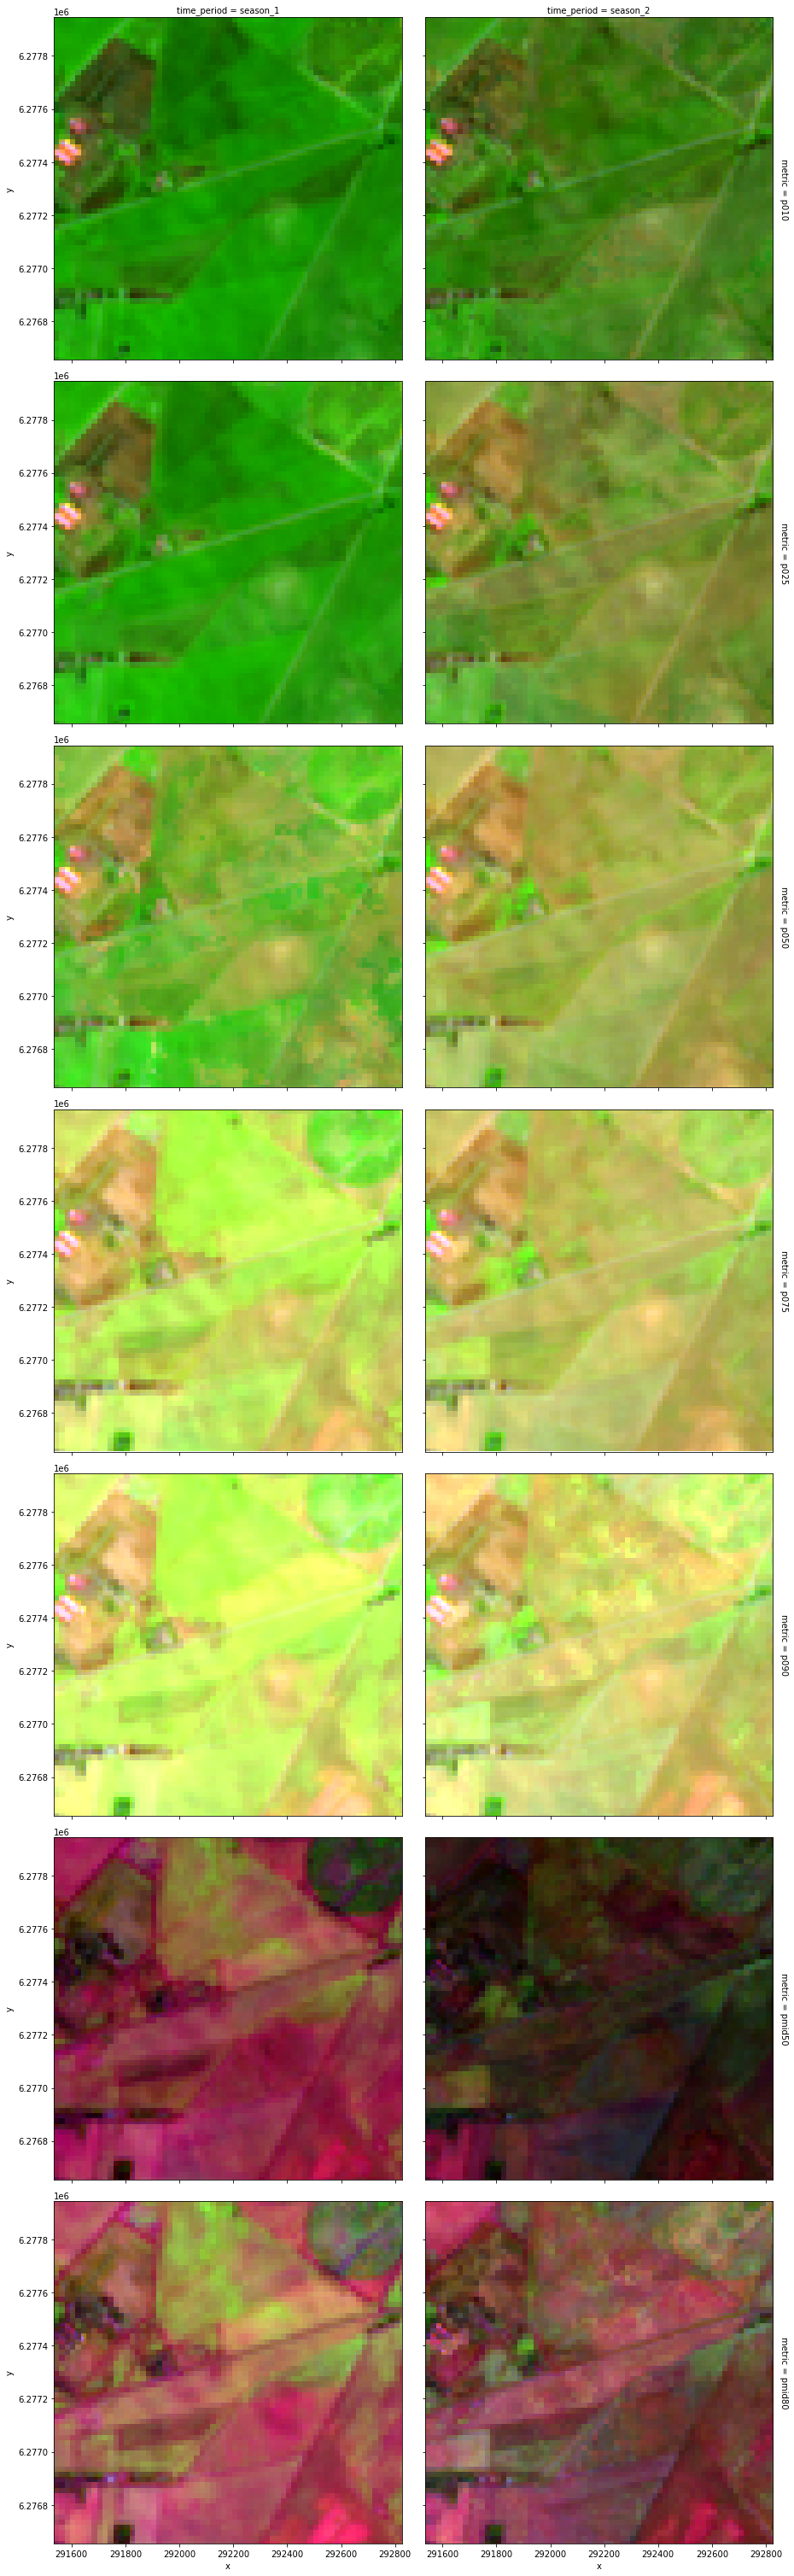

In [20]:
# SWIR
chip.viz_compare_time_periods(bands=["B12", "B8A", "B04"],
                              metrics=['p010', 'p025', 'p050', 'p075', 'p090', 'pmid50', 'pmid80'])

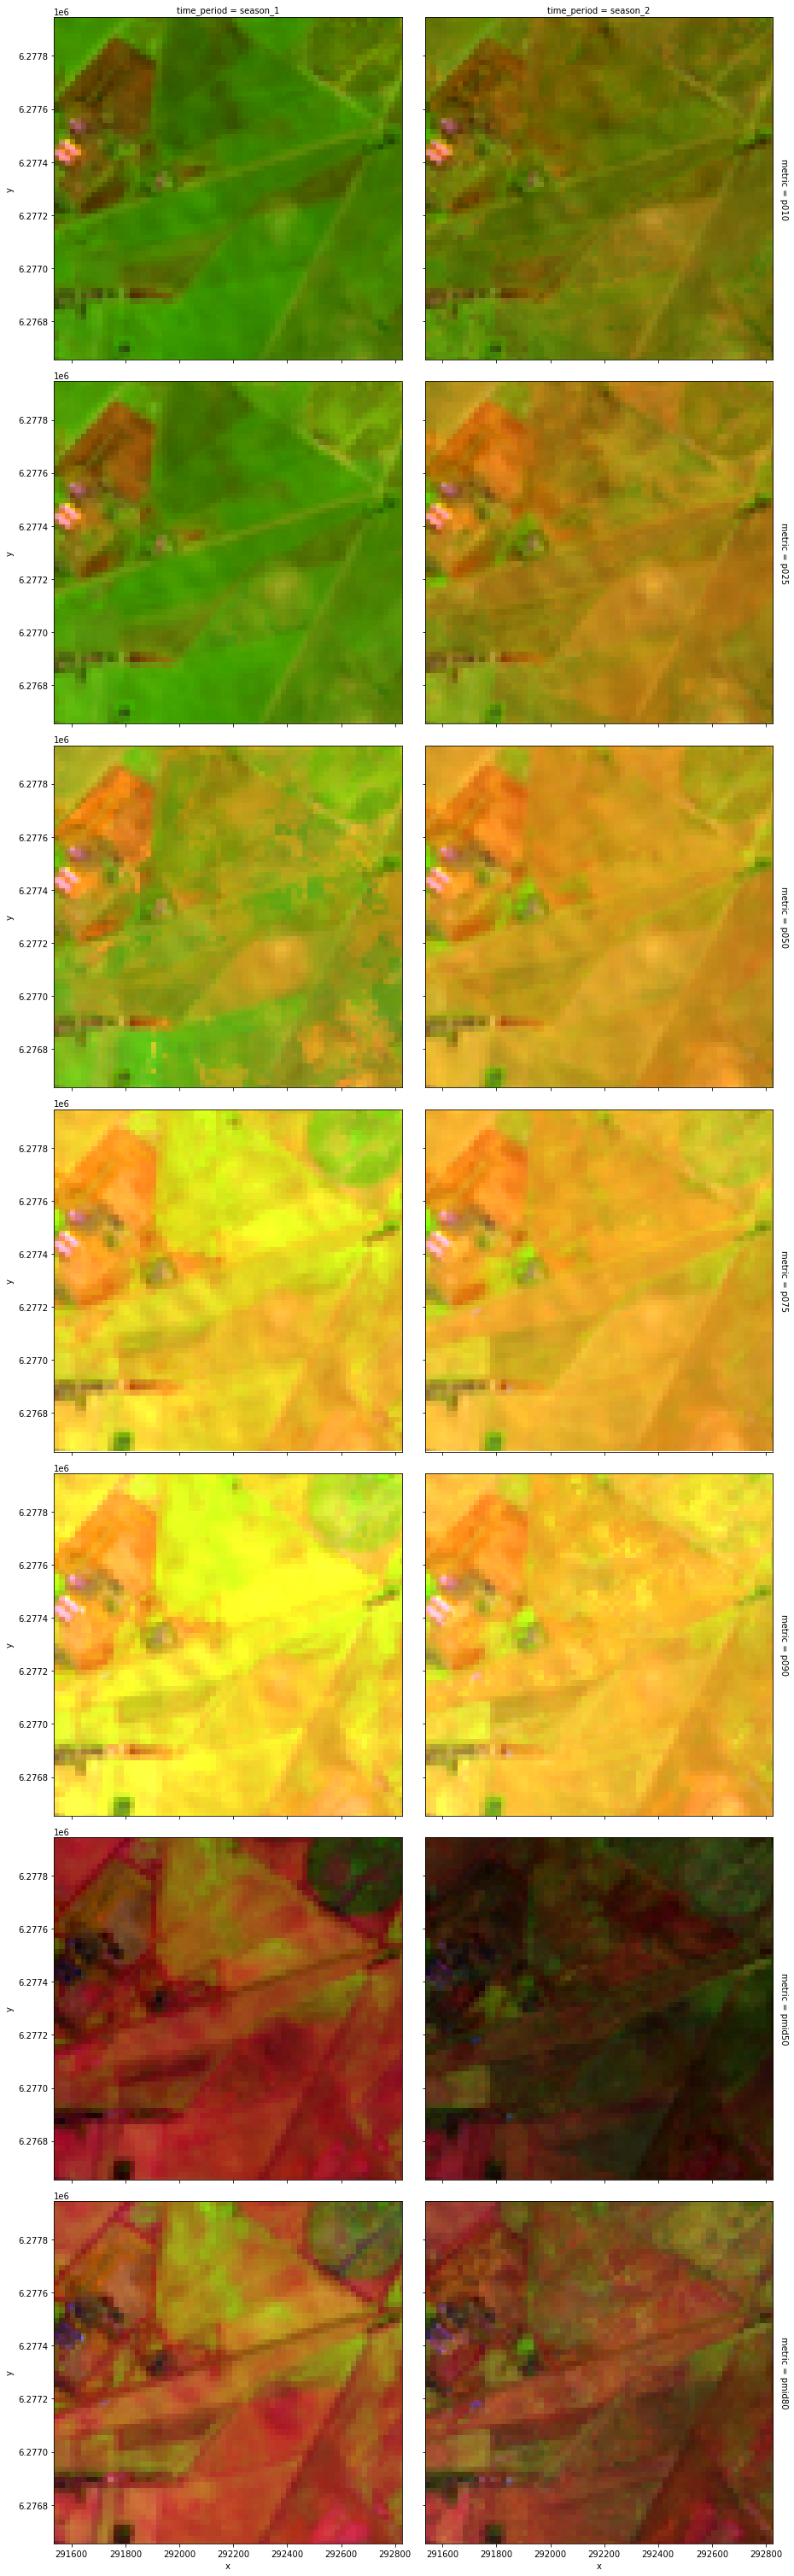

In [21]:
# Agriculture
chip.viz_compare_time_periods(bands=["B11", "B8A", "B02"],
                              metrics=['p010', 'p025', 'p050', 'p075', 'p090', 'pmid50', 'pmid80'])